# 強化学習 - Policy Gradient
迷路を解く強化学習のデモンストレーション

In [4]:
# パッケージのインポート
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

## 迷路の作成

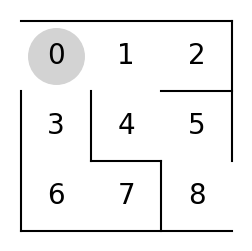

In [5]:
fig = plt.figure(figsize=(3, 3))

# 壁
plt.plot([0, 3], [3, 3], color='k')
plt.plot([0, 3], [0, 0], color='k')
plt.plot([0, 0], [0, 2], color='k')
plt.plot([3, 3], [3, 1], color='k')
plt.plot([1, 1], [1, 2], color='k')
plt.plot([2, 3], [2, 2], color='k')
plt.plot([2, 1], [1, 1], color='k')
plt.plot([2, 2], [0, 1], color='k')

# 数字
for i in range(3):
    for j in range(3):
        plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha='center', va='center')

# 円
circle, = plt.plot([0.5], [2.5], marker='o', color='#d3d3d3', markersize=40)

plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

## パラメータθの初期値の準備

In [6]:
theta_0 = np.array([
    [np.nan, 1, 1, np.nan], # 0 上,右,下,左
    [np.nan, 1, 1, 1], # 1
    [np.nan, np.nan, np.nan, 1], # 2
    [1, np.nan, 1, np.nan], # 3
    [1, 1, np.nan, np.nan], # 4
    [np.nan, np.nan, 1, 1], # 5
    [1, 1, np.nan, np.nan], # 6
    [np.nan, np.nan, np.nan, 1]]) # 7

## パラメータθを方策に変換

In [7]:
def get_pi(theta):
    # ソフトマックス関数で変換
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    exp_theta = np.exp(theta)
    for i in range(0, m):
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
    pi = np.nan_to_num(pi)
    return pi

In [8]:
# パラメータθの初期値を方策に変換
pi_0 = get_pi(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.         1.        ]]


## 方策に従って行動を取得

In [9]:
def get_a(pi, s):
    # 方策の確率に従って行動を返す
    return np.random.choice([0, 1, 2, 3], p=pi[s])

## 行動に従って次の状態を取得

In [10]:
def get_s_next(s, a):
    if a == 0: # 上
        return s - 3
    elif a == 1: # 右
        return s + 1
    elif a == 2: # 下
        return s + 3
    elif a == 3: # 左
        return s - 1

## 1エピソード実行して履歴取得

In [11]:
def play(pi):
    s = 0 # 状態
    s_a_history = [[0, np.nan]] # 状態と行動の履歴
    
    # エピソード完了までループ
    while True:
        # 方策に従って行動を取得
        a = get_a(pi, s)
        
        # 行動に従って次の状態を取得
        s_next = get_s_next(s, a)
        
        # 履歴の更新
        s_a_history[-1][1] = a     
        s_a_history.append([s_next, np.nan]) 
        
        # 終了判定
        if s_next == 8:
            break
        else:
            s = s_next
            
    return s_a_history

In [12]:
# 1エピソードの実行と履歴の確認
s_a_history = play(pi_0)
print(s_a_history)
print('1エピソードのステップ数：{}'.format(len(s_a_history)+1))

[[0, np.int64(2)], [3, np.int64(0)], [0, np.int64(1)], [1, np.int64(1)], [2, np.int64(3)], [1, np.int64(2)], [4, np.int64(0)], [1, np.int64(1)], [2, np.int64(3)], [1, np.int64(3)], [0, np.int64(1)], [1, np.int64(1)], [2, np.int64(3)], [1, np.int64(3)], [0, np.int64(2)], [3, np.int64(0)], [0, np.int64(2)], [3, np.int64(0)], [0, np.int64(2)], [3, np.int64(0)], [0, np.int64(1)], [1, np.int64(2)], [4, np.int64(0)], [1, np.int64(3)], [0, np.int64(2)], [3, np.int64(2)], [6, np.int64(1)], [7, np.int64(3)], [6, np.int64(1)], [7, np.int64(3)], [6, np.int64(1)], [7, np.int64(3)], [6, np.int64(1)], [7, np.int64(3)], [6, np.int64(0)], [3, np.int64(0)], [0, np.int64(1)], [1, np.int64(2)], [4, np.int64(1)], [5, np.int64(2)], [8, nan]]
1エピソードのステップ数：42


## パラメータθの更新関数

In [13]:
def update_theta(theta, pi, s_a_history):
    eta = 0.1 # 学習係数
    total = len(s_a_history) - 1 # ゴールまでにかかった総ステップ数
    [s_count, a_count] = theta.shape # 状態数, 行動数

    # パラメータθの変化量の計算
    delta_theta = theta.copy()
    for i in range(0, s_count):
        for j in range(0, a_count):
            if not(np.isnan(theta[i, j])):
                # ある状態である行動を採る回数
                sa_ij = [sa for sa in s_a_history if sa == [i, j]]
                n_ij = len(sa_ij)

                # ある状態でなんらかの行動を採る回数
                sa_i = [sa for sa in s_a_history if sa[0] == i]
                n_i = len(sa_i)

                # パラメータθの変化量
                delta_theta[i, j] = (n_ij - pi[i, j] * n_i) / total

    # パラメータθの更新
    return theta + eta * delta_theta

## 学習ループ

In [14]:
stop_epsilon = 10**-4 # しきい値
theta = theta_0 # パラメータθ
pi = pi_0 # 方策

# エピソードを繰り返し実行して学習
for episode in range(10000):
    # 1エピソード実行して履歴取得
    s_a_history = play(pi)
    
    # パラメータθの更新
    theta = update_theta(theta, pi, s_a_history)
    
    # 方策の更新
    pi_new = get_pi(theta)
    
    # 方策の変化量
    pi_delta = np.sum(np.abs(pi_new-pi))
    pi = pi_new    
    
    # 出力
    print('エピソード: {}, ステップ： {}, 方策変化量: {:.4f}'.format(
        episode, len(s_a_history)-1, pi_delta))
    
    # 終了判定
    if pi_delta < stop_epsilon: # 方策の変化量がしきい値以下
        break

エピソード: 0, ステップ： 6, 方策変化量: 0.0316
エピソード: 1, ステップ： 28, 方策変化量: 0.0091
エピソード: 2, ステップ： 10, 方策変化量: 0.0187
エピソード: 3, ステップ： 20, 方策変化量: 0.0120
エピソード: 4, ステップ： 12, 方策変化量: 0.0160
エピソード: 5, ステップ： 34, 方策変化量: 0.0094
エピソード: 6, ステップ： 24, 方策変化量: 0.0094
エピソード: 7, ステップ： 56, 方策変化量: 0.0067
エピソード: 8, ステップ： 92, 方策変化量: 0.0107
エピソード: 9, ステップ： 6, 方策変化量: 0.0400
エピソード: 10, ステップ： 44, 方策変化量: 0.0211
エピソード: 11, ステップ： 126, 方策変化量: 0.0076
エピソード: 12, ステップ： 88, 方策変化量: 0.0086
エピソード: 13, ステップ： 4, 方策変化量: 0.0477
エピソード: 14, ステップ： 48, 方策変化量: 0.0136
エピソード: 15, ステップ： 20, 方策変化量: 0.0125
エピソード: 16, ステップ： 102, 方策変化量: 0.0091
エピソード: 17, ステップ： 16, 方策変化量: 0.0316
エピソード: 18, ステップ： 60, 方策変化量: 0.0090
エピソード: 19, ステップ： 54, 方策変化量: 0.0092
エピソード: 20, ステップ： 4, 方策変化量: 0.0474
エピソード: 21, ステップ： 100, 方策変化量: 0.0063
エピソード: 22, ステップ： 8, 方策変化量: 0.0248
エピソード: 23, ステップ： 22, 方策変化量: 0.0111
エピソード: 24, ステップ： 20, 方策変化量: 0.0179
エピソード: 25, ステップ： 44, 方策変化量: 0.0132
エピソード: 26, ステップ： 18, 方策変化量: 0.0288
エピソード: 27, ステップ： 60, 方策変化量: 0.0133
エピソード: 28, ステップ： 12, 方策変化量: 0.01

## アニメーション表示

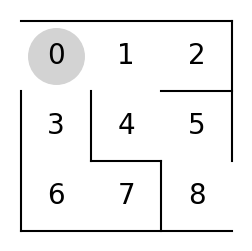

In [17]:
# 迷路を再描画
fig = plt.figure(figsize=(3, 3))

# 壁
plt.plot([0, 3], [3, 3], color='k')
plt.plot([0, 3], [0, 0], color='k')
plt.plot([0, 0], [0, 2], color='k')
plt.plot([3, 3], [3, 1], color='k')
plt.plot([1, 1], [1, 2], color='k')
plt.plot([2, 3], [2, 2], color='k')
plt.plot([2, 1], [1, 1], color='k')
plt.plot([2, 2], [0, 1], color='k')

# 数字
for i in range(3):
    for j in range(3):
        plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha='center', va='center')

# 円
circle, = plt.plot([0.5], [2.5], marker='o', color='#d3d3d3', markersize=40)

plt.axis('off')
plt.xticks([])
plt.yticks([])

# アニメーションの定期処理を行う関数
def animate(i):
    state = s_a_history[i][0]
    circle.set_data([(state % 3) + 0.5], [2.5 - int(state / 3)])
    return circle

# アニメーションの表示
anim = animation.FuncAnimation(fig, animate, \
        frames=len(s_a_history), interval=200, repeat=False)
HTML(anim.to_jshtml())